In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-nearest-earth-objects/neo_v2.csv
/kaggle/input/nasa-nearest-earth-objects/neo.csv


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, f1_score,accuracy_score,confusion_matrix,recall_score,precision_recall_curve,roc_curve,roc_auc_score
from sklearn.svm import SVC

In [3]:
df = pd.read_csv('/kaggle/input/nasa-nearest-earth-objects/neo.csv')  # converting CSV file to Data Frame
df.head() 

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
df.info() # describes the values of columns present in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [13]:
df_false = df[df.hazardous==False]    # creates a dataframe with False values of target variable 
df_true = df[df.hazardous==True]      # creates a dataframe with True values of target variable

In [14]:
x = df.drop(['id','name','orbiting_body','sentry_object','hazardous'],axis='columns') # dropping irrelevant columns from dataframe 
y = df.hazardous #dataframe containg target variable

In [15]:
# list containing relevant feature names for visualisations
feature_names = ['est_diameter_min','est_diameter_max','relative_velocity','miss_distance','absolute_magnitude']

In [16]:
# splits the datasets into training and test datasets
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3, random_state = 111)

In [17]:
# scaling of features
Scaler = StandardScaler() # creates scaler object
x_train_scaled = Scaler.fit_transform(x_train[x_train.columns]) # scales the features
x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train.columns, index = x_train.index) # converts the scaled data back to a dataframe

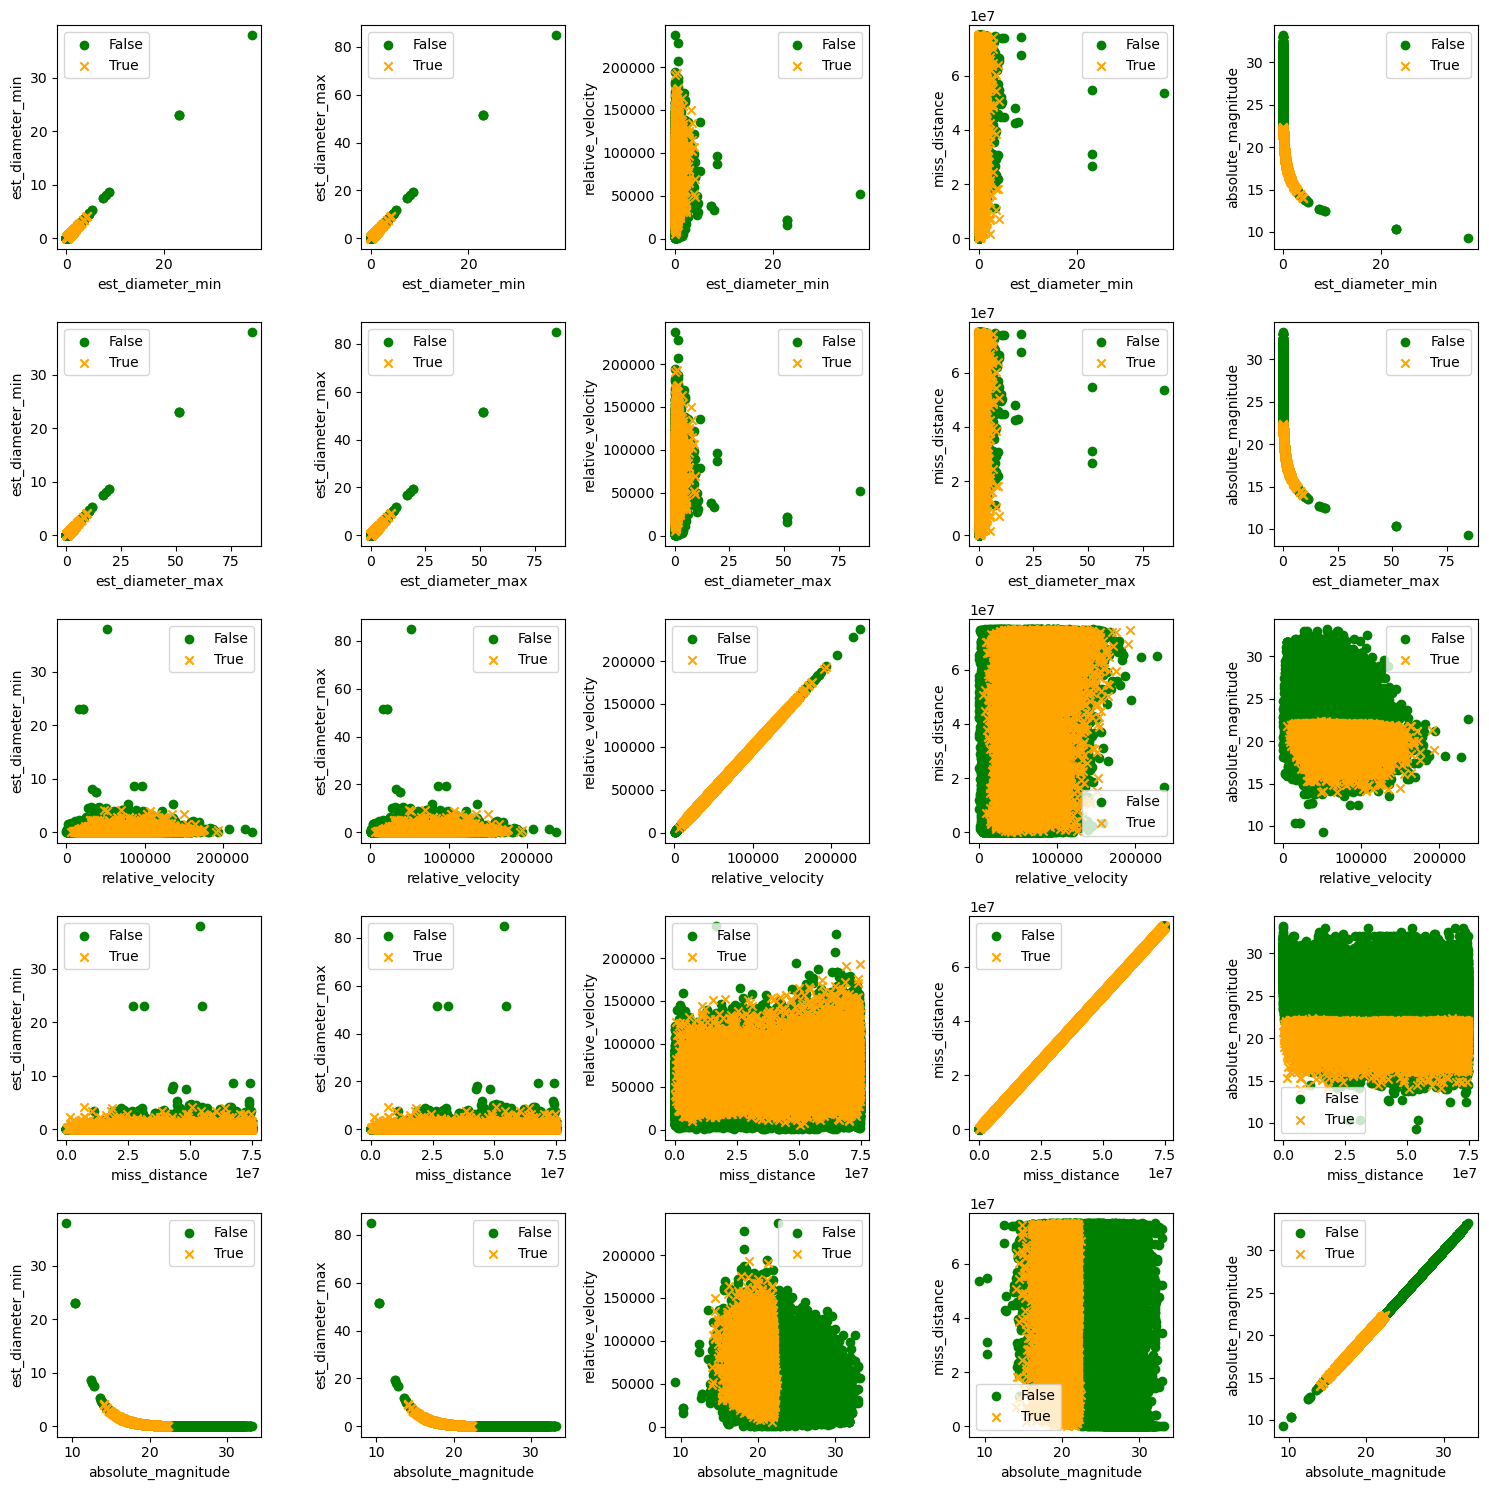

In [18]:
# Visualisation (pair - wise) of target variable values dependency on values of features
fig, axes = plt.subplots(len(feature_names), len(feature_names), figsize=(15, 15))

for i, col_x in enumerate(feature_names):
    for j, col_y in enumerate(feature_names):
        axes[i, j].scatter(df_false[col_x], df_false[col_y], marker='o', color='green', label='False') #plots data points for hazardous == False
        axes[i, j].scatter(df_true[col_x], df_true[col_y], marker='x', color='orange', label='True')  # #plots data points for hazardous == True
        axes[i, j].set_xlabel(col_x)
        axes[i, j].set_ylabel(col_y)
        axes[i, j].legend()

plt.tight_layout()
plt.show()     

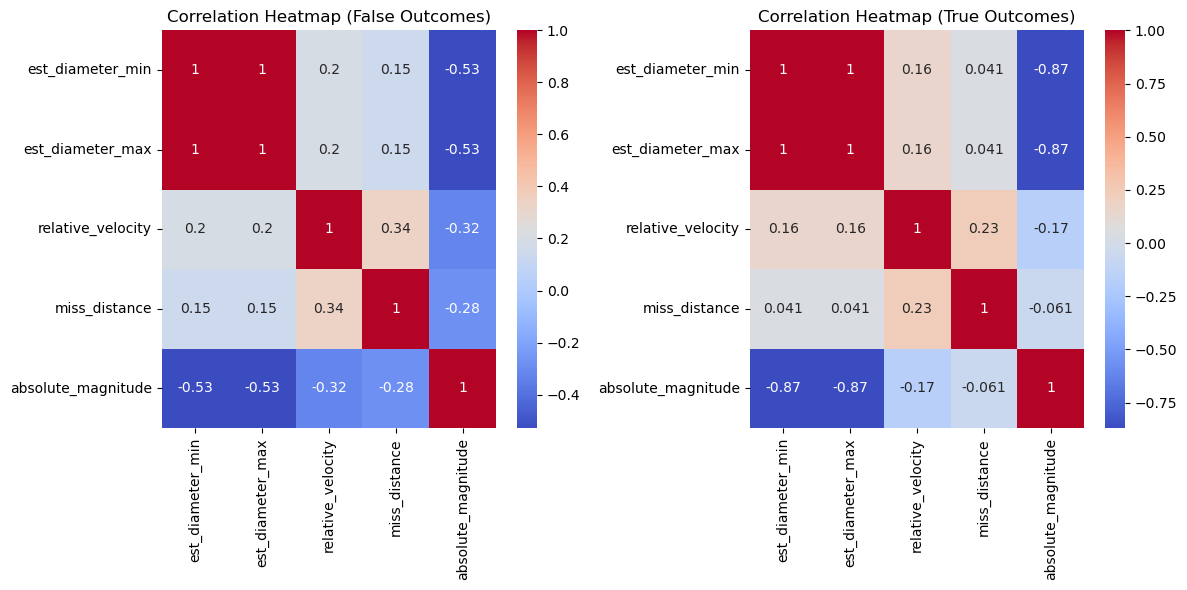

In [20]:
#visualising interdependency of pair-wise features on each other using correlation heatmaps
import seaborn as sns

# Extract the feature values for the heatmap
heatmap_data_false = df_false[feature_names]
heatmap_data_true = df_true[feature_names]

correlation_matrix_false = heatmap_data_false.corr()  # Creating correlation matrices for false outcomes
correlation_matrix_true = heatmap_data_true.corr()    # Create correlation matrices for true outcomes

# Generate the heatmaps for false and true outcomes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.heatmap(correlation_matrix_false, annot=True, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Correlation Heatmap (False Outcomes)")

sns.heatmap(correlation_matrix_true, annot=True, cmap="coolwarm", ax=ax[1])
ax[1].set_title("Correlation Heatmap (True Outcomes)")

plt.tight_layout()
plt.show()

In [27]:
# Training SVM model on the dataset for different kernels, and storing various metrics
kernels = ['rbf','sigmoid','poly']
kernel_ar = []
models = []

for kernel_ in kernels:
    model = SVC(kernel = kernel_, gamma = 'scale')      #Initialising SVM model with required kernel typr
    model.fit(x_train,y_train)            # training the model on the dataset
    
    models.append(model)
    
    y_predicted = model.predict(x_test) # predicts outcome for the test dataset
    
    #defining metrics
    score = model.score(x_test,y_test) # model score
    precision = precision_score(y_predicted,y_test,average = 'weighted') # average='weighted' to avoid ill-precision error
    f1Score  = f1_score(y_predicted,y_test,average = 'weighted') # f1 score
    cnfs_matrix = confusion_matrix(y_test,y_predicted) # confusion matrix
    accuracy = accuracy_score(y_test,y_predicted) # accuracy score
    recall = recall_score(y_test, y_predicted) # recall 
    tn, fp, fn, tp = cnfs_matrix.ravel() # extracts data required to calculate speicificity
    specificity = tn / (tn + fp) #specificity
    
    kernel_ar.append({'Kernel':kernel_,'y_pred':y_predicted,'Score':score,'Precision':precision,'f1Score':f1Score,'cnfs_matrix':cnfs_matrix,'Accuracy':accuracy,'Recall':recall,'Specificity':specificity})
    

In [34]:
comp_columns = ['Kernel','Score','Precision','f1Score','Accuracy','Recall','Specificity'] # Required Columns for comparision
comp_table = pd.DataFrame.from_dict(kernel_ar)[comp_columns] # converting array to dataframe

print('Comparision of different Kernels\' performance on various metrics is as follows : ')
display(comp_table) #displays the dataframe contating evaluation parameters



Comparision of different Kernels' performance on various metrics is as follows : 


,Kernel,Score,Precision,f1Score,Accuracy,Recall,Specificity
0,rbf,0.903600,1.00000,0.949359,0.903600,0.000000,1.000000
1,sigmoid,0.821695,0.81763,0.819649,0.821695,0.101637,0.898514
2,poly,0.903600,1.00000,0.949359,0.903600,0.000000,1.000000


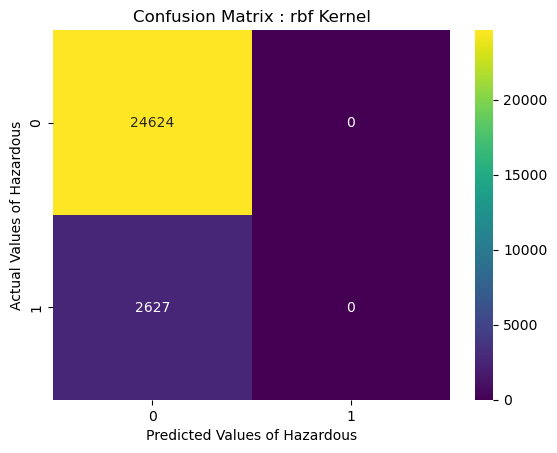

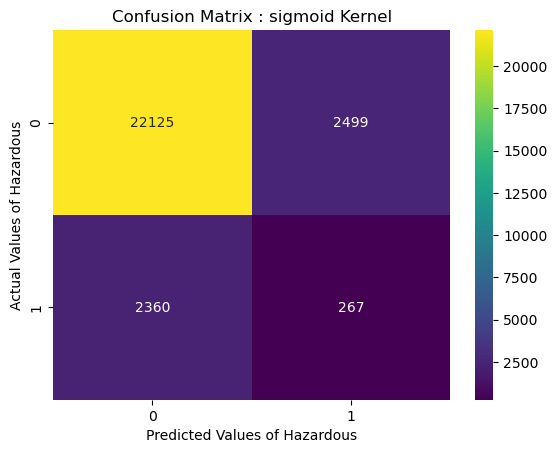

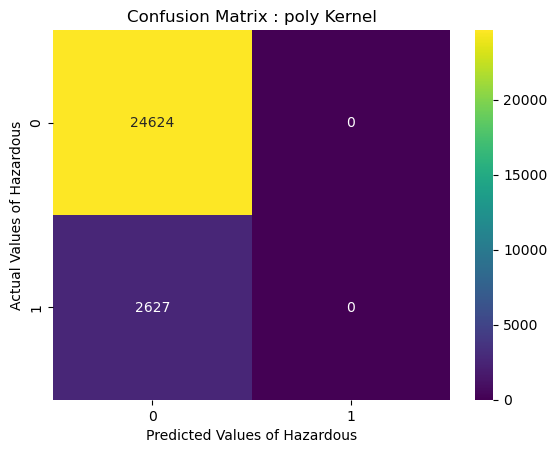

In [47]:
# Plots confusion matrix between the actual and predicted values for every kernel type
for kernel in kernel_ar:
    plt.figure()
    sns.heatmap(kernel['cnfs_matrix'],annot=True,cmap="viridis",fmt='g')
    plt.ylabel('Actual Values of Hazardous')
    plt.xlabel('Predicted Values of Hazardous')
    plt.title(f'Confusion Matrix : {kernel["Kernel"]} Kernel')
    

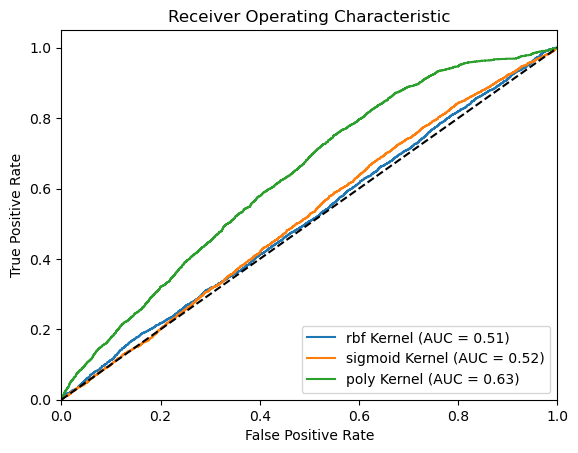

In [49]:
# Plotting ROC curve for further visualisation
for i, model in enumerate(models):
    y_pred_prob = model.decision_function(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{kernels[i]} Kernel (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

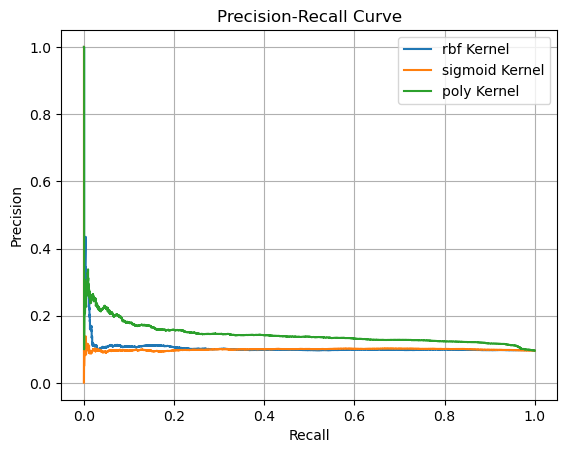

In [50]:
#Plotting Precision_Recall Curve for further viusalitsation
for i, model in enumerate(models):
    y_pred_prob = model.decision_function(x_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    plt.plot(recall, precision, label=f"{kernels[i]} Kernel")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()